In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt

Configure the Device for gpu or cpu

In [32]:
#Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
print(device)

cuda


Setup Hyper parameters for the model

In [34]:
#Hyperparameters
num_epochs = 5 # amount of times the model will see the data
batch_size = 64 # amount of data to be processed at once
learning_rate = 0.001 # gradient descent step size

Load the data

In [35]:
#Transform image Data
# transforms the data into a tensor and normilizes it
# transform = transforms.Compose(
#             [transforms.ToTensor(),
#             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
''' normalizes the data to be between -1 and 1 
    Color images have three channels (red, green, blue),therefore you need three parameters to normalize
    each channel.The first tuple (0.5, 0.5, 0.5) is the mean for all three channels 
    and the second (0.5, 0.5, 0.5) is the standard deviation for all three channels.
    if data value is 0 then when normalized we have:
    (0 - 0.5(mean)) / 0.5(std) = -1
    if data value is 1 then when normalized we have:
    (1 - 0.5) / 0.5 = 1
'''
# We could also turn the data into grayscale images by using:
# this will turn the values between 0 and 1
# 0 = black and 1 = white and in between is a shade of gray
transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Grayscale(num_output_channels=1)]) 
labels = ['angry', 'disgust', 'fear', 'happy','neutral', 'sad', 'surprise']

In [36]:
#Load Data
train_dataset = torchvision.datasets.ImageFolder(root='emotion_dataset/train', transform=transform)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)# pin_memory = True will copy the data to the GPU faster
test_dataset = torchvision.datasets.ImageFolder(root='emotion_dataset/test', transform=transform)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) # pin_memory = True will copy the data to the GPU faster

In [37]:
images, labels_as_nums = next(iter(train_data_loader))
print(labels_as_nums)
# first number in the shape is the batch size
# second number in the shape is the number of channels
# third number in the shape is the height of the image
# fourth number in the shape is the width of the image

tensor([0, 4, 5, 4, 3, 0, 3, 2, 5, 0, 3, 3, 5, 4, 3, 4, 3, 0, 2, 6, 2, 2, 0, 4,
        0, 5, 4, 6, 0, 6, 3, 3, 0, 4, 2, 3, 0, 3, 3, 5, 0, 5, 4, 3, 2, 3, 4, 3,
        6, 5, 6, 5, 4, 6, 5, 3, 3, 4, 3, 2, 0, 0, 3, 0])


In [38]:

# the train_data_loader has 2 elements, the first element is the image data and the second element is the labels
# the image data is a tensor of shape (batch_size, channels, height, width)
# the labels are a tensor of shape (batch_size)
# if we do images[0][0] we are getting the first image in the batch
# if we do images[0] we are getting the whole batch of images
# if we do images[1] we are getting the whole batch of labels


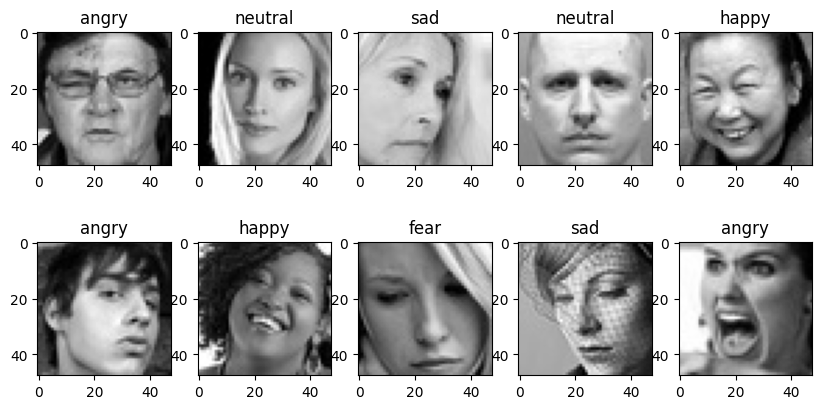

In [39]:
from matplotlib import image as mpimg

subplots = plt.subplots(2, 5, figsize=(10, 5))
# show the image
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(labels[labels_as_nums[i]])


In [40]:
print('Using device:', device)
# Print some basic information about the train and test datasets
print('Number of training examples: {}'.format(len(train_dataset)))
print('Number of test examples: {}'.format(len(test_dataset)))
print('Batch size: {}'.format(batch_size))

# Print some basic information about the train and test loaders
print('Number of training batches: {}'.format(len(train_data_loader)))
print('Number of test batches: {}'.format(len(test_data_loader)))

# Check the range of the pixel values in the training images
print("Minimum pixel value:", torch.min(images))
print("Maximum pixel value:", torch.max(images))

Using device: cuda
Number of training examples: 28709
Number of test examples: 7178
Batch size: 64
Number of training batches: 449
Number of test batches: 113
Minimum pixel value: tensor(0.)
Maximum pixel value: tensor(0.9999)


In [41]:
# class Net(nn.Module):
#     def __init__(self): 
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=1)  # the receptor field (kernel) is 3x3, stride=1, so each channel is of size 46x46x128 x = nn.BatchNorm2d(128),        
#         # self.norm1 = nn.BatchNorm2d(64)
#         self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=1) #kernel is 3x3, stride is 1, so output feature map is 42x42x128,        
#         # self.norm2 = nn.BatchNorm2d(64)
#         self.max_pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) #new output will be 22x22x128,,        
        
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1) #the receptor field (kernel) is 3x3, stride=1, so each channel is of size 46x46x64?,        
#         # self.norm3 = nn.BatchNorm2d(128)     
#         self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=1) #kernel is 3x3, stride is 1, so output feature map is 64,        
#         # self.norm4 = nn.BatchNorm2d(128)      
#         self.max_pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) #new output will be 9x9,,        
        
#         self.dropout1 = nn.Dropout(0.25)        
#         self.dropout2 = nn.Dropout(0.5)        
#         self.fc1 = nn.Linear(9*9*128, 128) #3*3*64=576,        
#         self.norm5 = nn.BatchNorm1d(128)        
#         self.fc2 = nn.Linear(128, 7) #we have seven classes


In [42]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding="same"), # --> 48x48x64
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding="same"), # --> 48x48x64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # --> 24x24x64
            
            nn.Conv2d(64, 128, kernel_size=3, padding="same"), # --> 24x24x128
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding="same"), # --> 24x24x128
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # --> 12x12x128
            
            nn.Conv2d(128, 256, kernel_size=3, padding="same"), # --> 12x12x256
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding="same"), # --> 12x12x256
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding="same"), # --> 12x12x256
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # --> 6x6x256
            
            nn.Conv2d(256, 512, kernel_size=3, padding="same"), # --> 6x6x512
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding="same"),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding="same"),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # --> 3x3x512
            
            nn.Conv2d(512, 512, kernel_size=3, padding="same"),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding="same"),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding="same"),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # --> 1x1x512
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 7),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [43]:
def train(model: VGGNet, optimizer, loss_function,device,train_data_loader):
    model.train() # tells python that the model is training

    for idx, (images, labels) in enumerate(train_data_loader):
        images, labels = images.to(device), labels.to(device)
        # clear our gradients
        optimizer.zero_grad()
        # foward pass
        output = model.forward(images)
        # calculate loss
        loss = loss_function(output, labels)
        # calculate the gradients
        loss.backward() # just calculates the gradients
        optimizer.step() # updates the parameters
        if idx % 25 == 0:
            print(f"loss = {loss}")

In [44]:
def test(model, device, test_loader):
    model.eval() #tells torch we're evaluating (not training) the model
    test_loss = 0 #store the test loss
    correct = 0 #store the number of images the model got correct from the test set 
    with torch.no_grad(): #important, otherwise torch will calculate the gradients for backpropagation. 
        for data, target in test_loader: #iterate through each image in the test set
            data, target = data.to(device), target.to(device)
            output = model(data) #run the data through the model
            test_loss += F.cross_entropy(output, target)  # sum up batch loss

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the predicted class
            #print(f"test pred: {pred.shape}") #32x1
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGGNet().to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()
epochs = 1

for epoch in range(epochs):
    train(model=model, optimizer=optimizer, loss_function=loss_function, device=device,train_data_loader=train_data_loader)
    test(model=model, device=device, test_loader=test_data_loader)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 3.46 GiB already allocated; 0 bytes free; 3.47 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF